## Load libraries

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1) 
 
# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Read in Data and Examine

In [2]:
xl = pd.ExcelFile('H2S-C3H8-data.xlsx')
pdd = {}
plot_kw = {}
for name in xl.sheet_names:
    pdd[name] = xl.parse(name,skiprows=2)
    if 'Smoothed data?' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Smoothed data?':'Smoothed?'})
    if 'Set' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Set':'Rejected?'})
    for col in ('Smoothed?', 'Rejected?'):
        if col in pdd[name].columns:
             pdd[name][col] = ~pdd[name][col].isnull();
    print(name)
    print(pdd[name].head())

    for source in pdd[name]['Source']:
        plot_kw[source] = {}

azeotropic P
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic pressure/ kPa COMMENT  
0  1378.95                   NaN     
1  2068.43                   NaN     
2  2757.90                   NaN     
3  3447.38                   NaN     
4  4136.85                   NaN     
x azeotrope
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic

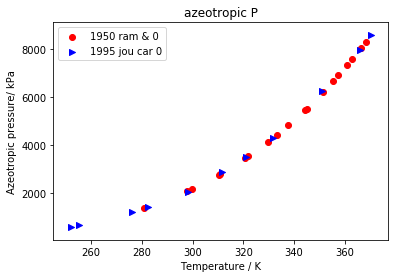

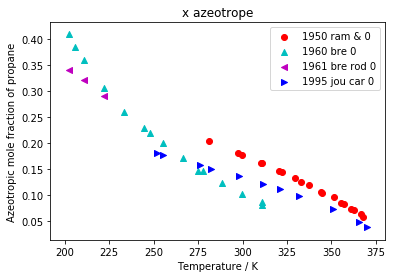

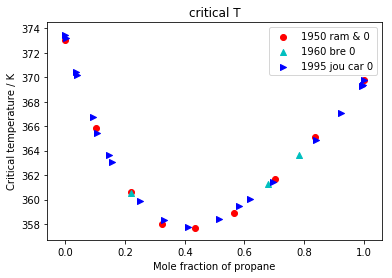

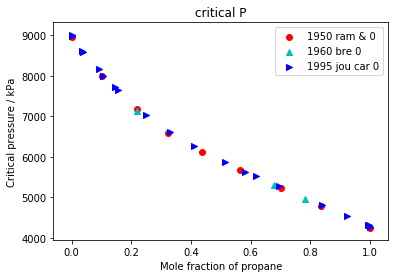

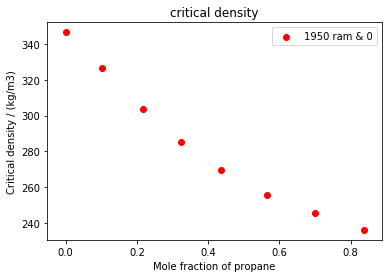

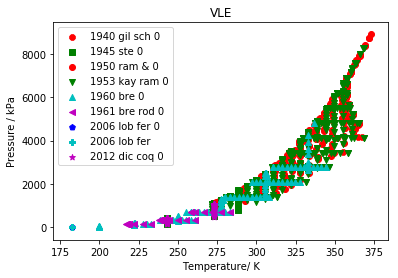

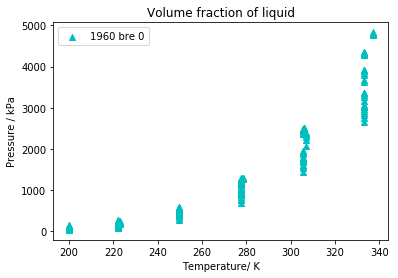

In [ ]:
markers = ['o', 'v', '>', '^', '<', '8', 's', 'p', 'P', '*', 'h', 'H', 'x', 'D']
colors  = ['r', 'g', 'b', 'c', 'm']
for (i, src) in zip (np.arange(0,len(plot_kw)), plot_kw):
    plot_kw[src]['c'] = colors[i % len(colors)]
    plot_kw[src]['marker'] = markers[i % len(markers)]
    plot_kw[src]['label'] = src

plots = [['azeotropic P', 'Temperature / K', 'Azeotropic pressure/ kPa'],
         ['x azeotrope',  'Temperature / K', 'Azeotropic mole fraction of propane'],    
         ['critical T',  'Mole fraction of propane', 'Critical temperature / K'],    
         ['critical P',  'Mole fraction of propane', 'Critical pressure / kPa'],    
         ['critical density',  'Mole fraction of propane', 'Critical density / (kg/m3)'],    
         ['VLE',  'Temperature/ K', 'Pressure / kPa'],    
         ['Volume fraction of liquid',  'Temperature/ K', 'Pressure / kPa'],    
         ['SLE',  'Liquid mole fraction of propane', 'SLE temperature / K'],    
         ['Saturated density of liquid',  'Liquid mole fraction of propane', 'Temperature/ K'],    
        ]

def plot_set(df, x=None, y=None, title=None, axes=None):
    if not x:
        x = df.columns[0]
    if not y:
        y = df.columns[1]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    for src in df['Source'].unique():
        mask = (df['Source']==src) & (df[x].notnull()) & (df[y].notnull())
        if 'Rejected?' in df.columns:
            mask &= ~df['Rejected?'].astype(bool)
        if len(df[[x,y]][mask]) == 0:
            continue
        axes.scatter(df[x][mask],
                     df[y][mask],
                     **plot_kw[src]
                    )
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    axes.legend()

for (title, x, y) in plots:
    plot_set(pdd[title], x, y, title)

### Define some standard terms, so that columns are consistent
This is all done in __[markdown](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)__, taking advantage of __[MathJax](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)__

In [ ]:
p = '$p$ / kPa'
T = '$T$ / K'
xC3 = '$x_{\mathrm{C}_3\mathrm{H}_8}$'  # Here, we've used the notation that x = liquid, y = vapor
yC3 = '$y_{\mathrm{C}_3\mathrm{H}_8}$'  # This nomenclature is not consistent across disciplines.
rho = '$\\rho$ / $\mathrm{kg}\\cdot\mathrm{m}^{-3}$'
Vfrac = '$V_\mathrm{L} / V$'
rejected = 'Rejected?'
smoothed = 'Smoothed?'

### Format and plot azeotrope data

In [ ]:
az_df = pdd['azeotropic P'].drop(columns='#').merge(pdd['x azeotrope'].drop(columns='#'),how='outer')
az_df = az_df.rename(columns={'Temperature / K':T,
                              'Azeotropic pressure/ kPa':p,
                              'Azeotropic mole fraction of propane':xC3,
                              'COMMENT': 'Comment'})
az_df = az_df[az_df.columns[[0,3,4,6,1,2,5]]]

def color_row(row, color='LightCoral', field='Rejected?', value=True):
    '''
    Reformat a row based upon certain values.
    '''
    attr = 'color: {}'.format(color)
    return [attr if row[field] == value else ''] * len(row)

def color_nan(value, color='lightgray'):
    '''
    Reformat a cell based upon a certain value.
    '''
    attr = 'color: {}'.format(color)
    return attr if type(value) == float and np.isnan(value) else ''

az_df.style.apply(color_row, axis=1). \
            applymap(color_nan).      \
            format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}'})

In [ ]:
def hist_set(df, prop=None, title=None, axes=None):
    if not prop:
        prop = df.columns[0]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    sources = df['Source'].unique()
    x = pd.DataFrame()
    for src in sources:
        mask = df['Source']==src
        if rejected in df.columns:
            mask &= ~df[rejected].astype(bool)
        target = df[prop][mask].dropna()
        if len(target) == 0:
            sources = np.delete(sources, np.where(sources == src), axis=0)
            continue
        x = pd.concat([x, target], ignore_index=True, axis=1)
    
    axes.hist(x.transpose(), color=list(map(lambda src: plot_kw[src]['c'], sources)), label=sources)
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(prop)
    axes.set_ylabel("occurrence")
    axes.legend()

def plot_grid(df, columns, title=None):
    n = len(columns)
    fig, axes = plt.subplots(n,n, figsize=(12, 10), sharex='col')
    for i in np.arange(n):
        for j in np.arange(n):
            if (i < j):
                axes[i,j].axis('off')
                continue
            if (i == j):
                hist_set(df, columns[i], axes=axes[i,i])
            else:
                plot_set(df, columns[j], columns[i], axes=axes[i,j])
    if title:
        fig.suptitle(title, fontsize=24)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# np.warnings.filterwarnings('ignore')
plot_grid(az_df, az_df.columns[[1,2,3]], title='Azeotropic Data')

### Format and plot critical data

In [ ]:
crit_df = pdd['critical T'].drop(columns='#').merge(pdd['critical P'].drop(columns='#'),how='outer')  \
          .merge(pdd['critical density'].drop(columns='#'),how='outer')
crit_df = crit_df.rename(columns={'Mole fraction of propane':xC3,
                                  'Critical temperature / K':T,
                                  'Critical pressure / kPa':p,
                                  'Critical density / (kg/m3)':rho,
                                  'COMMENT': 'Comment'})
crit_df = crit_df[crit_df.columns[[0,2,3,5,6,1,4]]]
crit_df.style.apply(color_row, axis=1).                             \
              applymap(color_nan).                                  \
              set_properties(subset=[rho], **{'width': '8em'}).     \
              format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}', rho: '{:0.2f}'})

In [ ]:
plot_grid(crit_df, crit_df.columns[[1,2,3,4]], title='Critical Data')

### Vapor-Liquid Equilibrium

## REFPROP
```
pip install ctREFPROP
```
https://github.com/usnistgov/REFPROP-wrappers